In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_path = 'Adversarial_traffic_Both.csv'

In [3]:
data = pd.read_csv(data_path)  # Adjust delimiter if needed

def construct_payload(row):
    dlc = int(row["DLC"])  # Number of valid data columns
    data_values = [row[f"Data{i}"] for i in range(1, dlc + 1) if f"Data{i}" in row]
    return "".join(map(str, data_values))

data["Data"] = data.apply(construct_payload, axis=1)
# Keep only the required columns
data = data[["TS", "ID", "DLC", "Data", "Label"]]
## Rename the columns to Timestamp, ID, DLC, Data, and Label
data.columns = ["Timestamp", "ID", "DLC", "Data", "label"]

# Save the transformed data
# data.to_csv("transformed_file.csv", index=False)

# Display the transformed DataFrame
data.head()

,Timestamp,ID,DLC,Data,label
0,0.000000,2fb,8,de3de7fc77d18619,2
1,0.005492,643,8,de5f417c9b4d34db,2
2,0.011240,140,8,000000001c072628,0
3,0.016786,6df,8,05b06567dfdff49d,2
4,0.017052,316,8,052174092120006f,0


In [4]:
hex_to_dec = lambda x: int(str(x), 16)

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Data'] = data['Data'].apply(hex_to_dec)

    return data

data = transform_data(data)


In [5]:
data.head()

,Timestamp,ID,DLC,Data,label
0,0.000000,763,8,16014210921527346713,2
1,0.005492,1603,8,16023598002644792539,2
2,0.011240,320,8,470230568,0
3,0.016786,1759,8,409939062902748317,2
4,0.017052,790,8,369704226980364399,0


In [6]:
data['label'].replace(2,1, inplace=True)
data['label'].replace(3,1, inplace=True)
data.head()

/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_19357/3424221442.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['label'].replace(2,1, inplace=True)
/var/folders/pw/3vr89zzj1xvbzvtk1yfz9kkc0000gn/T/ipykernel_19357/3424221442.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

,Timestamp,ID,DLC,Data,label
0,0.000000,763,8,16014210921527346713,1
1,0.005492,1603,8,16023598002644792539,1
2,0.011240,320,8,470230568,0
3,0.016786,1759,8,409939062902748317,1
4,0.017052,790,8,369704226980364399,0


In [7]:
def split_into_windows(df, window_size):
    """
    Split dataset into windows of a given size and assign a label to each window.
    
    Args:
        df (pd.DataFrame): Input dataframe.
        window_size (float): Window size in seconds.
        
    Returns:
        list: List of windowed dataframes.
        list: List of labels for each window (1 if any data point in the window is 1, else 0).
        int: Number of windows.
    """
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()
    
    windows = []
    window_labels = []  # To store the label for each window
    current_time = start_time
    
    while current_time <= end_time:
        # Extract data for the current window
        window = df[(df['Timestamp'] >= current_time) & 
                    (df['Timestamp'] < current_time + window_size)]
        
        if not window.empty:
            windows.append(window)
            
            # Assign window label: 1 if any label is 1 in the window, else 0
            if (window['label'] == 1).any():
                window_labels.append(1)
            else:
                window_labels.append(0)
        
        # Move to next window
        current_time += window_size
    
    return windows, window_labels, len(windows)

def calculate_entropy(windows):
    """
    Calculate entropy for each window.
    
    Args:
        windows (list): List of windowed dataframes.
        
    Returns:
        list: List of entropy values for each window.
    """
    entropies = []
    
    for window in windows:
        # Count unique combinations of Identifier, Data Length Code, and Data
        counts = window.groupby(['ID', 'DLC', 'Data']).size()
        total = counts.sum()
        
        if total > 0:
            # Compute probability
            probabilities = counts / total
            
            # Calculate entropy using the definition
            entropy = -np.sum(probabilities * np.log2(probabilities))
            entropies.append(entropy)
    
    return entropies

In [8]:
# entropy_dict = {}  # Dictionary to store entropy values by window size
# window_labels_dict = {}  # Stores window labels by window size

# window_sizes = [1, 0.5, 0.1]  # in seconds
# for window_size in window_sizes:
#     windows, window_labels, num_windows = split_into_windows(benign_data, window_size)
#     entropies = calculate_entropy(windows)
    
#     # Store entropy values in dictionary
#     entropy_dict[window_size] = entropies
#     window_labels_dict[window_size] = window_labels

    
#     print(f"Window size: {window_size} seconds")
#     print(f"Number of windows: {num_windows}")
#     print(f"Average entropy: {np.mean(entropies):.4f}\n")

# # Example: Access entropy values later
# print(entropy_dict[1])  # Entropy values for window size 1 second


def plot_entropy(entropy_dict, window_labels_dict, show_labels=True):
    """
    Plots entropy across time windows. If show_labels is True, creates separate plots 
    for each window size, distinguishing attack (label=1) and benign (label=0) windows.

    Args:
        entropy_dict (dict): Dictionary mapping window size to entropy values.
        window_labels_dict (dict): Dictionary mapping window size to window labels.
        show_labels (bool): Whether to plot attack and benign windows separately.
    """
    
    if show_labels:
        for window_size, entropies in entropy_dict.items():
            labels = window_labels_dict[window_size]
            x = np.arange(len(entropies))  # X-axis: Window indices
            
            attack_indices = [idx for idx, lbl in enumerate(labels) if lbl == 1]
            benign_indices = [idx for idx, lbl in enumerate(labels) if lbl == 0]

            plt.figure(figsize=(10, 5))
            
            plt.scatter(attack_indices, [entropies[idx] for idx in attack_indices], 
                        color='red', label='Attack', marker='x')

            plt.scatter(benign_indices, [entropies[idx] for idx in benign_indices], 
                        color='blue', label='Benign', marker='o')

            plt.title(f'Entropy Across Time Windows - Window Size {window_size}s')
            plt.xlabel('Window Index')
            plt.ylabel('Entropy')
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
        plt.figure(figsize=(12, 6))
        colors = ['blue', 'green', 'red']  # Colors for each window size
        
        for i, (window_size, entropies) in enumerate(entropy_dict.items()):
            x = np.arange(len(entropies))  # X-axis: Window indices
            plt.plot(x, entropies, label=f'Window size: {window_size}s', 
                     color=colors[i % len(colors)], marker='o', linestyle='-')

        #
        plt.xlabel('Window Index')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [9]:
entropy_dict = {}  # Dictionary to store entropy values by window size
window_labels_dict = {}  # Stores window labels by window size

window_sizes = [1, 0.5, 0.1]  # in seconds
for window_size in window_sizes:
    windows, window_labels, num_windows = split_into_windows(data, window_size)
    entropies = calculate_entropy(windows)
    
    # Store entropy values in dictionary
    entropy_dict[window_size] = entropies
    window_labels_dict[window_size] = window_labels

    
    print(f"Window size: {window_size} seconds")
    print(f"Number of windows: {num_windows}")
    print(f"Average entropy: {np.mean(entropies):.4f}\n")


Window size: 1 seconds
Number of windows: 67
Average entropy: 7.5850

Window size: 0.5 seconds
Number of windows: 134
Average entropy: 7.0391

Window size: 0.1 seconds
Number of windows: 669
Average entropy: 5.6298



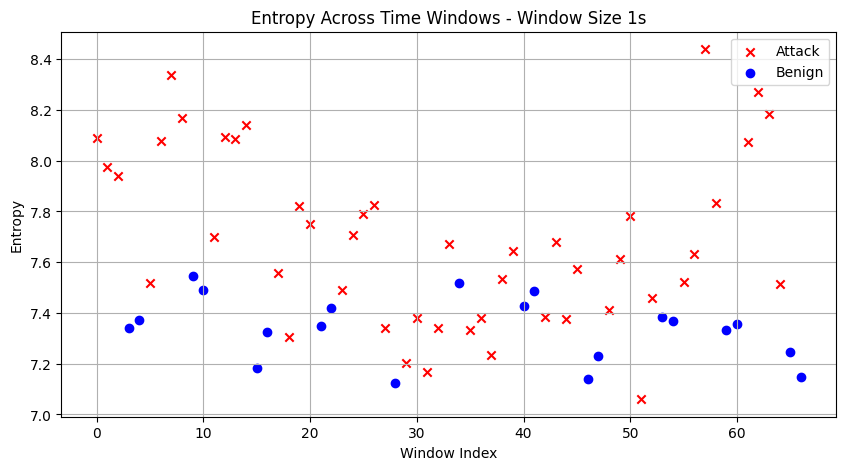

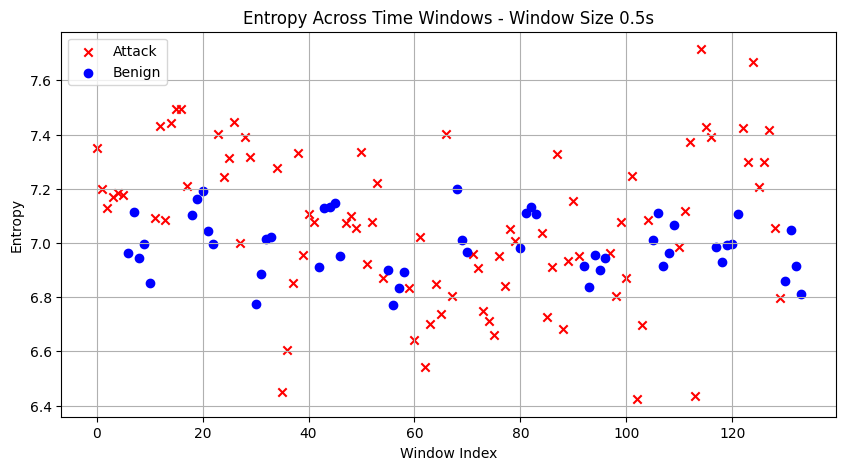

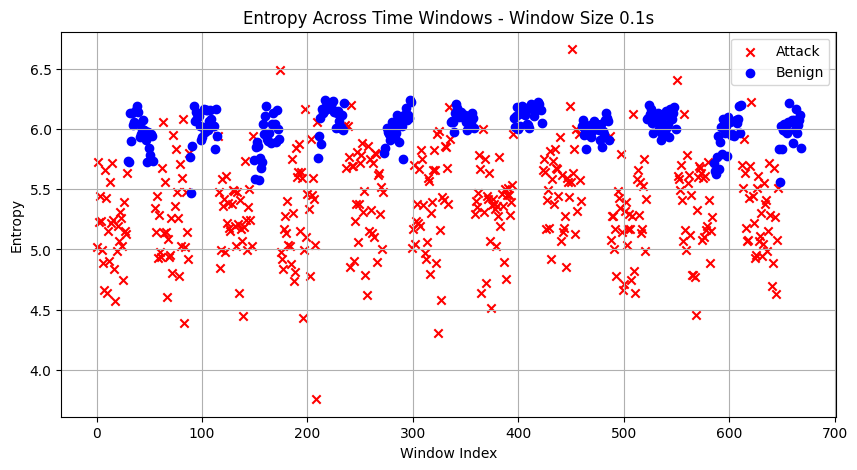

In [10]:
plot_entropy(entropy_dict, window_labels_dict, show_labels=True) 

In [11]:
# entropy_dict[1]

In [12]:
# entropy_dict

In [13]:
## Get indices where the below list has value 1
window_1_labels = window_labels_dict[1]
window05_labels = window_labels_dict[0.5]
window01_labels = window_labels_dict[0.1]

In [14]:
print("Length of window_1: ", len(window_1_labels))
print("Length of window05: ", len(window05_labels))
print("Length of window01: ", len(window01_labels))

Length of window_1:  67
Length of window05:  134
Length of window01:  669


In [15]:
train_size = 0.3

train_window_01_labels, test_window_01_labels = window01_labels[0:int(train_size*len(window01_labels))], window01_labels[int(train_size*len(window01_labels)):]
train_window05_labels, test_window05_labels = window05_labels[0:int(train_size*len(window05_labels))], window05_labels[int(train_size*len(window05_labels)):]
train_window1_labels, test_window1_labels = window_1_labels[0:int(train_size*len(window_1_labels))], window_1_labels[int(train_size*len(window_1_labels)):]

train_window_01 = entropy_dict[0.1][0:int(train_size*len(window01_labels))]
benign_indices_01 = [idx for idx, lbl in enumerate(window01_labels[:int(train_size*len(window01_labels))]) if lbl == 0]
attack_indices_01 = [idx for idx, lbl in enumerate(window01_labels[:int(train_size*len(window01_labels))]) if lbl == 1]
train_window_01_benign = [train_window_01[i] for i in benign_indices_01]
test_window_01 = entropy_dict[0.1][int(train_size*len(window01_labels)):]

train_window_05 = entropy_dict[0.5][0:int(train_size*len(window05_labels))]
benign_indices_05 = [idx for idx, lbl in enumerate(window05_labels[:int(train_size*len(window05_labels))]) if lbl == 0]
attack_indices_05 = [idx for idx, lbl in enumerate(window05_labels[:int(train_size*len(window05_labels))]) if lbl == 1]
train_window_05_benign = [train_window_05[i] for i in benign_indices_05]
test_window_05 = entropy_dict[0.5][int(train_size*len(window05_labels)):]

train_window_1 = entropy_dict[1][0:int(train_size*len(window_1_labels))]
benign_indices_1 = [idx for idx, lbl in enumerate(window_1_labels[:int(train_size*len(window_1_labels))]) if lbl == 0]
attack_indices_01 = [idx for idx, lbl in enumerate(window_1_labels[:int(train_size*len(window_1_labels))]) if lbl == 1]
train_window_1_benign = [train_window_1[i] for i in benign_indices_1]
test_window_1 = entropy_dict[1][int(train_size*len(window_1_labels)):]

print("Train window 0.5: ", len(train_window_05_benign))
print("Test window 0.5: ", len(test_window_05))
print('\n')

print("Train window 0.1: ", len(train_window_01_benign))
print("Test window 0.1: ", len(test_window_01))
print('\n')

print("Train window 1: ", len(train_window_1_benign))
print("Test window 1: ", len(test_window_1))
print('\n')

Train window 0.5:  14
Test window 0.5:  94


Train window 0.1:  76
Test window 0.1:  469


Train window 1:  6
Test window 1:  47




In [16]:
# attack_indices_1 = [idx for idx, lbl in enumerate(window_1_labels) if lbl == 1]
# attack_indices_05 = [idx for idx, lbl in enumerate(window05_labels) if lbl == 1]
# attack_indices_01 = [idx for idx, lbl in enumerate(window01_labels) if lbl == 1]

# train_indices_1 = [idx for idx, lbl in enumerate(train_window_1) if lbl == 0]
# train_indices_05 = [idx for idx, lbl in enumerate(train_window_05) if lbl == 0]
# train_indices_01 = [idx for idx, lbl in enumerate(train_window_01) if lbl == 0]

In [17]:
## Get the entropy values for the benign indices
train_entropy_1 = [entropy_dict[1][i] for i in  benign_indices_1]
train_entropy_05 = [entropy_dict[0.5][i] for i in  benign_indices_05]
train_entropy_01 = [entropy_dict[0.1][i] for i in  benign_indices_01]

## Get the entropy values for the attack indices
train_entropy_attack_1 = [entropy_dict[1][i] for i in  attack_indices_01]
train_entropy_attack_05 = [entropy_dict[0.5][i] for i in  attack_indices_05]
train_entropy_attack_01 = [entropy_dict[0.1][i] for i in  attack_indices_01]

train_entropy_1_mean, train_entropy_1_std = np.mean(train_entropy_1), np.std(train_entropy_1)
train_entropy_05_mean, train_entropy_05_std = np.mean(train_entropy_05), np.std(train_entropy_05)
train_entropy_01_mean, train_entropy_01_std = np.mean(train_entropy_01), np.std(train_entropy_01)


print(f"Window size: 1 second")
print(f"Train entropy mean and std-dev: {train_entropy_1_mean:.4f}, {train_entropy_1_std:.4f}") 
print('\n')
print(f"Window size: 0.5 second")
print(f"Train entropy mean and std-dev: {train_entropy_05_mean:.4f}, {train_entropy_05_std:.4f}")
print('\n')
print(f"Window size: 0.1 second")
print(f"Train entropy mean and std-dev: {train_entropy_01_mean:.4f}, {train_entropy_01_std:.4f}")

Window size: 1 second
Train entropy mean and std-dev: 7.3757, 0.1175


Window size: 0.5 second
Train entropy mean and std-dev: 7.0039, 0.1134


Window size: 0.1 second
Train entropy mean and std-dev: 5.9657, 0.1595


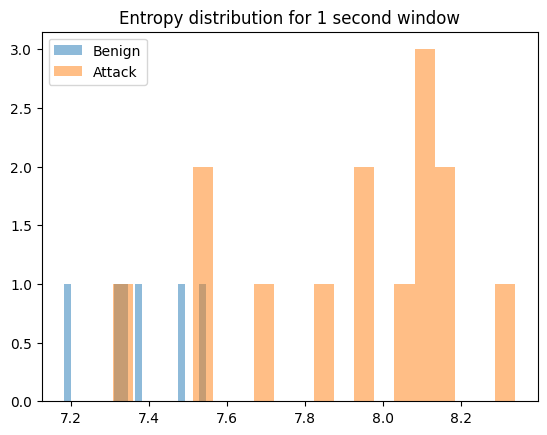

In [18]:
plt.hist(train_entropy_1, bins = 20, alpha = 0.5, label = 'Benign')
plt.hist(train_entropy_attack_1, bins = 20, alpha = 0.5, label = 'Attack')
plt.legend()
plt.title('Entropy distribution for 1 second window')
plt.show()

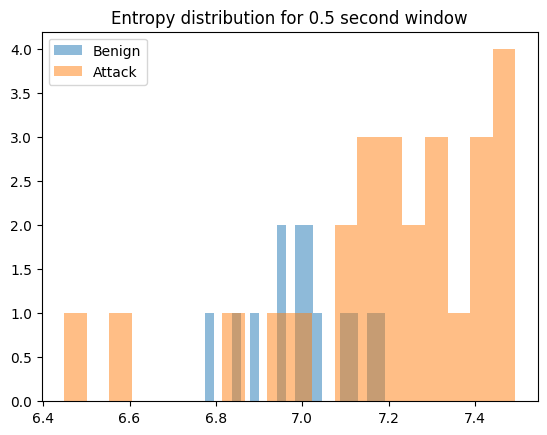

In [19]:
plt.hist(train_entropy_05, bins = 20, alpha = 0.5, label = 'Benign')
plt.hist(train_entropy_attack_05, bins = 20, alpha = 0.5, label = 'Attack')
plt.legend()
plt.title('Entropy distribution for 0.5 second window')
plt.show()

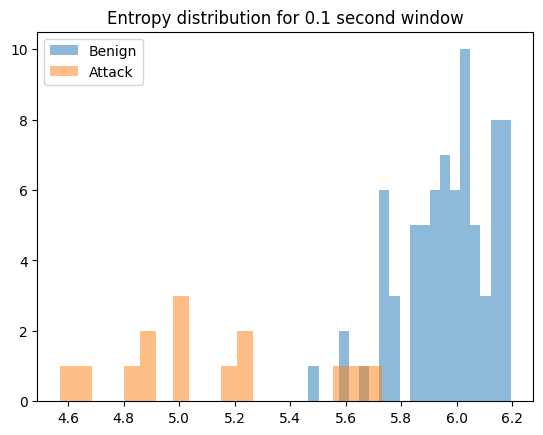

In [20]:
plt.hist(train_entropy_01, bins = 20, alpha = 0.5, label = 'Benign')
plt.hist(train_entropy_attack_01, bins = 20, alpha = 0.5, label = 'Attack')
plt.legend()
plt.title('Entropy distribution for 0.1 second window')
plt.show()

In [21]:
# test_attack_indices_1 = [idx for idx, lbl in enumerate(test_window1) if lbl == 1]
# test_attack_indices_05 = [idx for idx, lbl in enumerate(test_window05) if lbl == 1]
# attack_indices_01 = [idx for idx, lbl in enumerate(test_window_01) if lbl == 1]

# test_benign_indices_1 = [idx for idx, lbl in enumerate(test_window1) if lbl == 0]
# test_benign_indices_05 = [idx for idx, lbl in enumerate(test_window05) if lbl == 0]
# test_benign_indices_01 = [idx for idx, lbl in enumerate(test_window_01) if lbl == 0]

# train_benign_indices_1 = [idx for idx, lbl in enumerate(train_window1) if lbl == 0]
# train_bengin_indices_05 = [idx for idx, lbl in enumerate(train_window05) if lbl == 0]
# train_benign_indices_01 = [idx for idx, lbl in enumerate(train_window_01) if lbl == 0]

# ## Get the entropy values for the benign indices
# train_entropy_1 = [entropy_dict[1][i] for i in  train_benign_indices_1]
# train_entropy_05 = [entropy_dict[0.5][i] for i in  train_bengin_indices_05]
# train_entropy_01 = [entropy_dict[0.1][i] for i in  train_benign_indices_01]

# ## Get the entropy values for the attack indices
# entropy_attack_1 = [entropy_dict[1][i] for i in  attack_indices_1]
# entropy_attack_05 = [entropy_dict[0.5][i] for i in  attack_indices_05]
# entropy_attack_01 = [entropy_dict[0.1][i] for i in  attack_indices_01]

# entropy_1_mean, entropy_1_std, entropy_attack_1_mean, entropy_attack_1_std = np.mean(entropy_1), np.std(entropy_1), np.mean(entropy_attack_1), np.std(entropy_attack_1)
# entropy_05_mean, entropy_05_std, entropy_attack_05_mean, entropy_attack_05_std = np.mean(entropy_05), np.std(entropy_05), np.mean(entropy_attack_05), np.std(entropy_attack_05)
# entropy_01_mean, entropy_01_std, entropy_attack_01_mean, entropy_attack_01_std = np.mean(entropy_01), np.std(entropy_01), np.mean(entropy_attack_01), np.std(entropy_attack_01)

In [22]:
## threshold = [mean - k*std_dev, mean + k*std_dev]


def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

k_vals = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3]

for k in k_vals:
    threshold_1 = [train_entropy_1_mean - k*train_entropy_1_std, train_entropy_1_mean + k*train_entropy_1_std]
    threshold_05 = [train_entropy_05_mean - k*train_entropy_05_std, train_entropy_05_mean + k*train_entropy_05_std] 
    threshold_01 = [train_entropy_01_mean - k*train_entropy_01_std, train_entropy_01_mean + k*train_entropy_01_std]
    
    print(f"Threshold for k = {k}")
    print('\n')

    print(f"Window size: 1 second")
    print(f"Threshold: {threshold_1}")

    predicted_labels = detect_attack(test_window_1, threshold_1)
    print("Accuracy:", accuracy_score(test_window1_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window1_labels, predicted_labels))
    
    print(f"Window size: 0.5 second")
    print(f"Threshold: {threshold_05}")

    predicted_labels = detect_attack(test_window_05, threshold_05)
    print("Accuracy", accuracy_score(test_window05_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window05_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(test_window05_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')



    print(f"Window size: 0.1 second")
    print(f"Threshold: {threshold_01}")
    predicted_labels = detect_attack(test_window_01, threshold_01)
    print("Accuracy:",accuracy_score(test_window_01_labels, predicted_labels))
    print("classification Report")
    print(classification_report(test_window_01_labels, predicted_labels))

    tn, fp, fn, tp = confusion_matrix(test_window_01_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n\n\n')

Threshold for k = 0.1


Window size: 1 second
Threshold: [7.363938261438611, 7.387441695993865]
Accuracy: 0.6595744680851063
classification Report
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        14
           1       0.71      0.88      0.78        33

    accuracy                           0.66        47
   macro avg       0.52      0.51      0.49        47
weighted avg       0.60      0.66      0.61        47

Window size: 0.5 second
Threshold: [6.992590367531115, 7.015260664240278]
Accuracy 0.6595744680851063
classification Report
              precision    recall  f1-score   support

           0       0.80      0.11      0.20        35
           1       0.65      0.98      0.78        59

    accuracy                           0.66        94
   macro avg       0.73      0.55      0.49        94
weighted avg       0.71      0.66      0.57        94

True Positives (TP): 58 / 59 (Total Real Positives)
False Positives (FP): 3

In [23]:
def detect_attack(entropy, threshold):
    """
    Detects attack based on entropy values and threshold.
    
    Args:
        entropy (list): Entropy list.
        threshold (list): Lower and upper threshold values.
        
    Returns:
        predicted_labels (list): List of predicted labels (1 if attack, else 0).
    """
    predicted_labels = []
    
    for e in entropy:
        if e < threshold[0] or e > threshold[1]:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
    
    return predicted_labels

k_vals = [0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 9.5, 10]

best_accuracy_1 = 0
best_k_1 = 0
best_accuracy_05 = 0
best_k_05 = 0
best_accuracy_01 = 0
best_k_01 = 0

for k in k_vals:
    threshold_1 = [train_entropy_1_mean - k*train_entropy_1_std, train_entropy_1_mean + k*train_entropy_1_std]
    threshold_05 = [train_entropy_05_mean - k*train_entropy_05_std, train_entropy_05_mean + k*train_entropy_05_std] 
    threshold_01 = [train_entropy_01_mean - k*train_entropy_01_std, train_entropy_01_mean + k*train_entropy_01_std]
    
    print(f"Threshold for k = {k}")
    print('\n')

    print(f"Window size: 1 second")
    print(f"Threshold: {threshold_1}")

    predicted_labels = detect_attack(test_window_1, threshold_1)
    accuracy_1 = accuracy_score(test_window1_labels, predicted_labels)
    print("Accuracy:", accuracy_1)
    print("classification Report")
    print(classification_report(test_window1_labels, predicted_labels))
    if accuracy_1 > best_accuracy_1:
        best_accuracy_1 = accuracy_1
        best_k_1 = k

    tn, fp, fn, tp = confusion_matrix(test_window1_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


    print(f"Window size: 0.5 second")
    print(f"Threshold: {threshold_05}")

    predicted_labels = detect_attack(test_window_05, threshold_05)
    accuracy_05 = accuracy_score(test_window05_labels, predicted_labels)
    print("Accuracy", accuracy_05)
    print("classification Report")
    print(classification_report(test_window05_labels, predicted_labels))
    if accuracy_05 > best_accuracy_05:
        best_accuracy_05 = accuracy_05
        best_k_05 = k

    tn, fp, fn, tp = confusion_matrix(test_window05_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


    print(f"Window size: 0.1 second")
    print(f"Threshold: {threshold_01}")
    predicted_labels = detect_attack(test_window_01, threshold_01)
    accuracy_01 = accuracy_score(test_window_01_labels, predicted_labels)
    print("Accuracy:", accuracy_01)
    print("classification Report")
    print(classification_report(test_window_01_labels, predicted_labels))
    if accuracy_01 > best_accuracy_01:
        best_accuracy_01 = accuracy_01
        best_k_01 = k

    print('\n')

    tn, fp, fn, tp = confusion_matrix(test_window_01_labels, predicted_labels).ravel()

# Count of real positives and negatives
    total_positives = tp + fn
    total_negatives = tn + fp

    # Print the results
    print(f"True Positives (TP): {tp} / {total_positives} (Total Real Positives)")
    print(f"False Positives (FP): {fp} / {total_positives} (Total Real Positives)")
    print(f"True Negatives (TN): {tn} / {total_negatives} (Total Real Negatives)")
    print(f"False Negatives (FN): {fn} / {total_negatives} (Total Real Negatives)")
    print('\n')


print(f"Best k value for window size 1 second: {best_k_1} with accuracy {best_accuracy_1}")
print(f"Best k value for window size 0.5 second: {best_k_05} with accuracy {best_accuracy_05}")
print(f"Best k value for window size 0.1 second: {best_k_01} with accuracy {best_accuracy_01}")

Threshold for k = 0.1


Window size: 1 second
Threshold: [7.363938261438611, 7.387441695993865]
Accuracy: 0.6595744680851063
classification Report
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        14
           1       0.71      0.88      0.78        33

    accuracy                           0.66        47
   macro avg       0.52      0.51      0.49        47
weighted avg       0.60      0.66      0.61        47

True Positives (TP): 29 / 33 (Total Real Positives)
False Positives (FP): 12 / 33 (Total Real Positives)
True Negatives (TN): 2 / 14 (Total Real Negatives)
False Negatives (FN): 4 / 14 (Total Real Negatives)


Window size: 0.5 second
Threshold: [6.992590367531115, 7.015260664240278]
Accuracy 0.6595744680851063
classification Report
              precision    recall  f1-score   support

           0       0.80      0.11      0.20        35
           1       0.65      0.98      0.78        59

    accuracy                

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [24]:
data_path = '../../Smart Attack Algorithm/data/Car Hacking Dataset'

benign_data_path = os.path.join(data_path, 'benign_data.csv')
attack_data_path = os.path.join(data_path, 'DoS_dataset.csv')